<center>
<h1 style="color:red; font-size:70px;"> AWS Col de Porte data analysis </h1>

The aim of this notebook is to familiarise yourself with the xarray library, which contains the tools needed to extract information from NetCDF files. In particular, I would like to try to evaluate the trend in snow depth on the ground.

In [2]:
import numpy as np
import scipy as sp
import xarray as xr
import matplotlib.pyplot as plt

<h1 style="color:blue; font-size:50px;"> Snow height datas </h1>

The results of the measurements taken at Col de Porte are organised into netCDF files based on the observables taken into consideration. The only coordinate present is the time/date when the measurement of interest was taken, while there are as many as 70 variables taken into consideration. For the moment, we are focusing on snow depth, so that we can then carry out analyses of monthly averages and related trends, if any.

In [3]:
dat = xr.open_dataset("HourlySnow.nc")
dat

<xarray.Dataset> Size: 154MB
Dimensions:                   (time: 271752)
Coordinates:
  * time                      (time) datetime64[ns] 2MB 1993-08-01 ... 2024-0...
Data variables: (12/70)
    Soil_temperature_10cm     (time) float64 2MB ...
    Soil_temperature_20cm     (time) float64 2MB ...
    Soil_temperature_50cm     (time) float64 2MB ...
    Runoff_5m2                (time) float64 2MB ...
    Runoff_1m2                (time) float64 2MB ...
    Snow_depth                (time) float64 2MB ...
    ...                        ...
    Soil_moisture_10cm_2      (time) float64 2MB ...
    Soil_moisture_10cm_3      (time) float64 2MB ...
    Soil_moisture_20cm_1      (time) float64 2MB ...
    Soil_moisture_20cm_2      (time) float64 2MB ...
    Soil_moisture_30cm_1      (time) float64 2MB ...
    Soil_moisture_30cm_2      (time) float64 2MB ...

In [4]:
sh = dat['Snow_depth']
sh

<xarray.DataArray 'Snow_depth' (time: 271752)> Size: 2MB
[271752 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 2MB 1993-08-01 ... 2024-07-31T23:00:00
Attributes:
    units:    cm

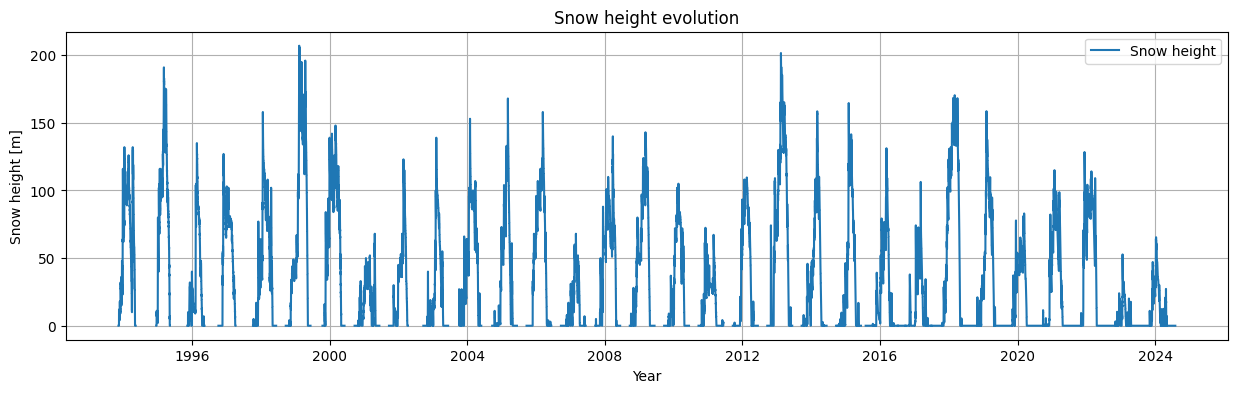

In [5]:
fig, ax = plt.subplots(figsize=(15, 4))

sh.plot(x="time", ax = ax, label="Snow height")
ax.set_title("Snow height evolution")
ax.set_ylabel("Snow height [m]")
ax.set_xlabel("Year")

ax.legend(loc="best")
ax.grid(True)

plt.show()

I note that initially no snow depth measurements were taken during the summer. To avoid introducing any bias linked to incorrect measurements caused by instrument malfunction, I will try to filter the data so that only those with more than 2 cm of snow cover are displayed on the screen. In any case, there are years characterised by particularly low snow depths, such as 2001, 2007, 2023 and 2024. At this site, no snow drought conditions were observed in 2022, which was particularly problematic in the Italian Alps.

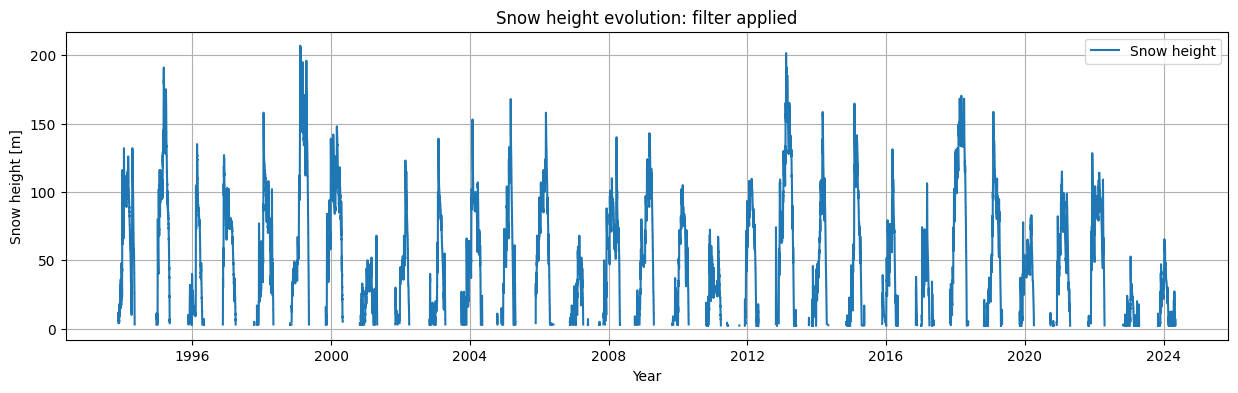

In [6]:
FILTER_VALUE = 2.0
appo = sh.where(sh > FILTER_VALUE)

fig, ax = plt.subplots(figsize=(15, 4))

appo.plot(x="time", ax = ax, label="Snow height")
ax.set_title("Snow height evolution: filter applied")
ax.set_ylabel("Snow height [m]")
ax.set_xlabel("Year")

ax.legend(loc="best")
ax.grid(True)

plt.show()

<h1 style="color:blue; font-size:50px;"> Monthly averages </h1>

We will now proceed to determine the monthly averages, so that we can assess which month has the highest average water equivalent and lay the foundations for researching any trends in the growth or decline of snow resources over time.

In [7]:
# Be careful about rounding
appo = np.zeros(shape = (6, 31))
anni = np.arange(1993, 2025, 1)
mesi = np.array(["01", "02", "03", "04", "11", "12"])

for j, year in enumerate(anni):
    for i, month in enumerate(mesi):

        # Checks required to print labels correctly and fill containers
        if year!=1993 and i<4:
            k = j-1
        elif year==1993 and i<4:
            continue
        elif year==2024 and i>=4:
            continue 
        else:
            k = j

        # Computing monthly snow height
        nome = str(year) + "-" + month
        sh_month = sh.sel(time=nome).mean()
        if np.isnan(sh_month):
            sh_month = 0.0
        else:
            sh_month = sh_month.item()

        sh_month = round(sh_month)
        appo[i, k] = sh_month

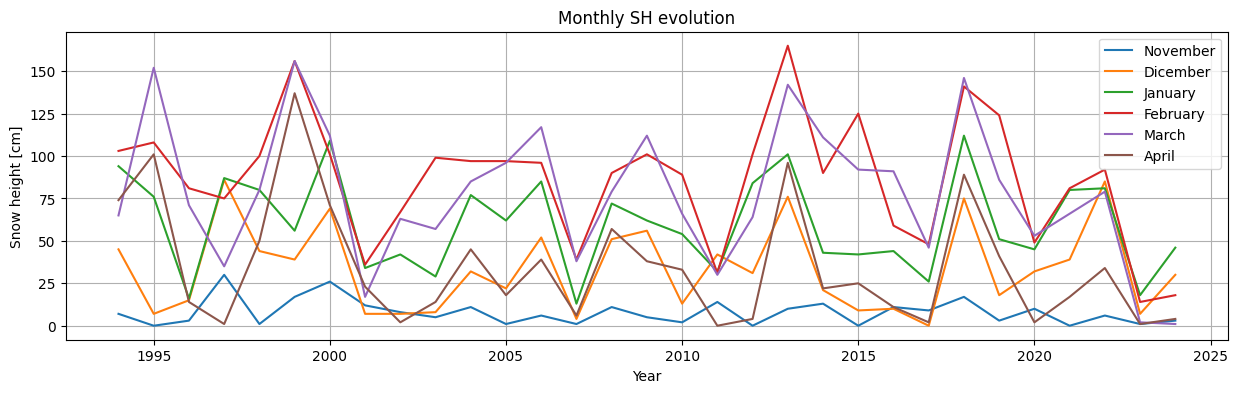

In [8]:
fig = plt.figure(figsize = (15, 4))
hydroY = np.arange(1994, 2025, 1)

plt.plot(hydroY, appo[4, :], label = "November")
plt.plot(hydroY, appo[5, :], label = "Dicember")
plt.plot(hydroY, appo[0, :], label = "January")
plt.plot(hydroY, appo[1, :], label = "February")
plt.plot(hydroY, appo[2, :], label = "March")
plt.plot(hydroY, appo[3, :], label = "April")

plt.title("Monthly SH evolution")
plt.ylabel("Snow height [cm]")
plt.xlabel("Year")

plt.legend(loc="best")
plt.grid(True)
plt.show()

I now evaluate the averages for each season of snow accumulation on the ground. The idea at this stage of the notebook is to reproduce a graph from the paper from which I obtained these data, so that I can see for myself whether the post-processing procedure is correct or not. Since the months have different lengths, I combine the previously determined values using a weighted average over the days.

In [9]:
shY = np.zeros(31)

for i in range(0, 31):
    shY[i] = (31*appo[4, i] + 31*appo[0, i] + 28*appo[1, i] + 31*appo[2, i] + 30*appo[3, i])/(31+31+28+31+30)

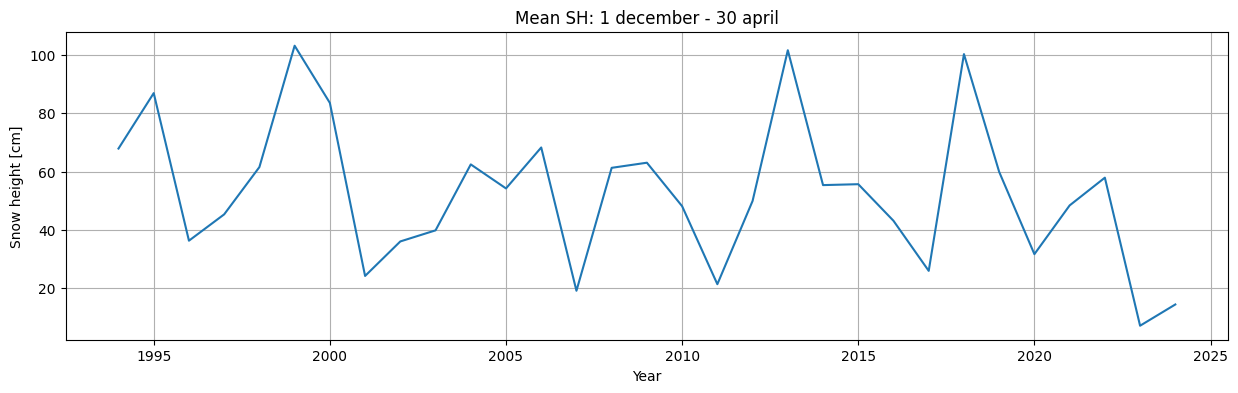

In [10]:
fig = plt.figure(figsize = (15, 4))
hydroY = np.arange(1994, 2025, 1)

plt.plot(hydroY, shY)


plt.title("Mean SH: 1 december - 30 april")
plt.ylabel("Snow height [cm]")
plt.xlabel("Year")

plt.grid(True)
plt.show()

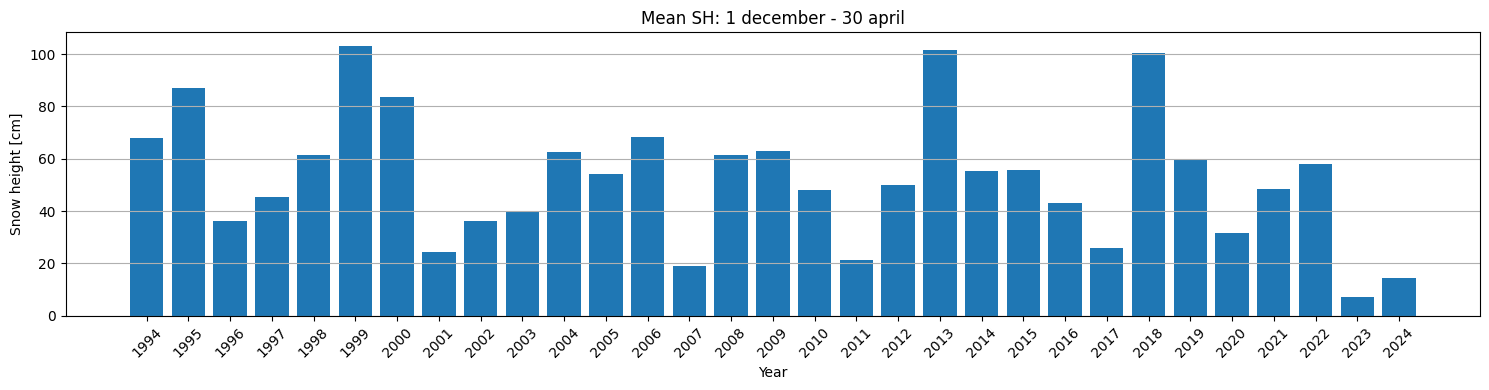

In [11]:
fig, ax = plt.subplots(figsize=(15, 4))
hydroY = np.arange(1994, 2025, 1)

ax.bar(hydroY, shY, width=0.8)

ax.set_title("Mean SH: 1 december - 30 april")
ax.set_ylabel("Snow height [cm]")
ax.set_xlabel("Year")

ax.set_xticks(hydroY)               
ax.tick_params(axis="x", rotation=45)

ax.grid(True, axis="y") 
plt.tight_layout()
plt.show()

<h1 style="color:blue; font-size:50px;"> Air temperature </h1>

I now evaluate the averages for each season of snow accumulation on the ground. The idea at this stage of the notebook is to reproduce a graph from the paper from which I obtained these data, so that I can see for myself whether the post-processing procedure is correct or not. Since the months have different lengths, I combine the previously determined values using a weighted average over the days.

In [12]:
dat = xr.open_dataset("MetInSitu.nc")
dat

<xarray.Dataset> Size: 17MB
Dimensions:       (time: 271815, Number_of_points: 1)
Coordinates:
  * time          (time) datetime64[ns] 2MB 1993-08-01T06:00:00 ... 2024-08-0...
Dimensions without coordinates: Number_of_points
Data variables: (12/23)
    FRC_TIME_STP  float32 4B ...
    CO2air        (time, Number_of_points) float32 1MB ...
    DIR_SWdown    (time, Number_of_points) float32 1MB ...
    flag          (time, Number_of_points) float32 1MB ...
    HUMREL        (time, Number_of_points) float32 1MB ...
    LWdown        (time, Number_of_points) float32 1MB ...
    ...            ...
    UREF          (Number_of_points) float32 4B ...
    ZREF          (Number_of_points) float32 4B ...
    ZS            (Number_of_points) float32 4B ...
    aspect        (Number_of_points) float32 4B ...
    slope         (Number_of_points) float32 4B ...
    station       (Number_of_points) float64 8B ...

In [13]:
ta = dat["Tair"]

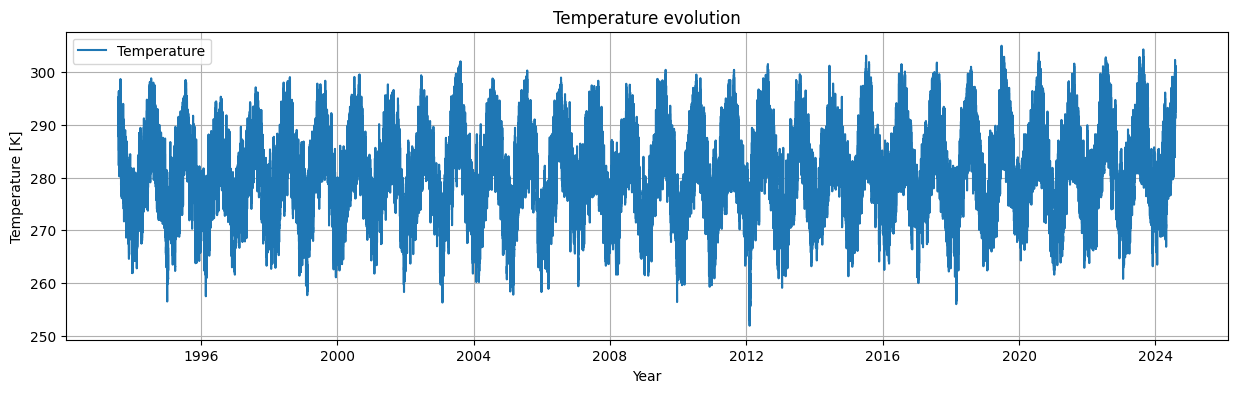

In [14]:
fig, ax = plt.subplots(figsize=(15, 4))

ta.plot(x="time", ax = ax, label="Temperature")
ax.set_title("Temperature evolution")
ax.set_ylabel("Temperature [K]")
ax.set_xlabel("Year")

ax.legend(loc="best")
ax.grid(True)

plt.show()

### Monthly scale

In [15]:
appo = np.zeros(shape = (12, 31))
anni = np.arange(1993, 2025, 1)
mesi = np.array(["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"])

for j, year in enumerate(anni):
    for i, month in enumerate(mesi):

        if year!=1993 and i<7:
            k = j-1
        elif year==1993 and i<7:
            continue
        elif year==2024 and i>=7:
            continue 
        else:
            k = j

        # Computing monthly air temperature
        nome = str(year) + "-" + month
        t_month = ta.sel(time=nome).mean()
        if np.isnan(t_month):
            t_month = 0.0
        else:
            t_month = t_month.item()
        
        appo[i, k] = t_month

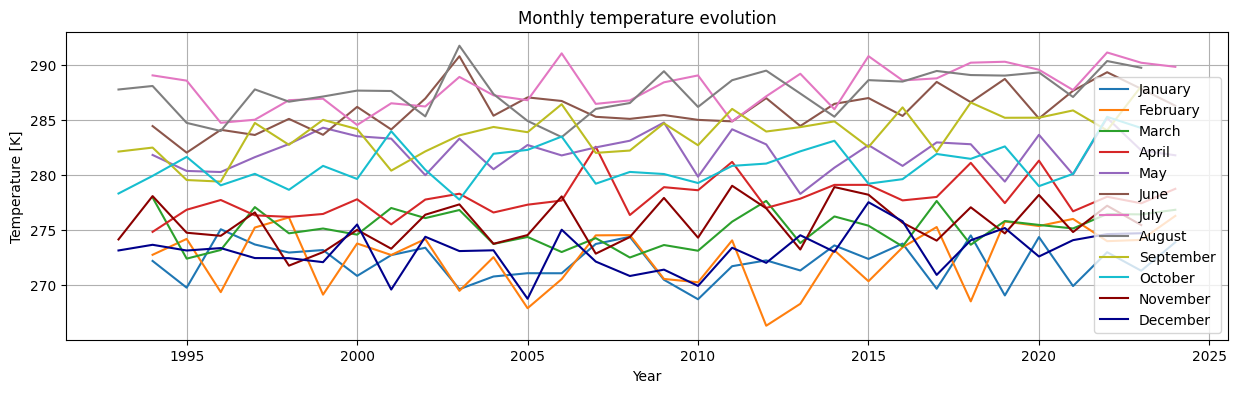

In [16]:
fig = plt.figure(figsize = (15, 4))
hydroY1 = np.arange(1994, 2025, 1)
hydroY2 = np.arange(1993, 2024, 1)

plt.plot(hydroY1, appo[0, :], label = "January")
plt.plot(hydroY1, appo[1, :], label = "February")
plt.plot(hydroY1, appo[2, :], label = "March")
plt.plot(hydroY1, appo[3, :], label = "April")
plt.plot(hydroY1, appo[4, :], label = "May")
plt.plot(hydroY1, appo[5, :], label = "June")
plt.plot(hydroY1, appo[6, :], label = "July")
plt.plot(hydroY2, appo[7, :], label = "August")
plt.plot(hydroY2, appo[8, :], label = "September")
plt.plot(hydroY2, appo[9, :], label = "October")
plt.plot(hydroY2, appo[10, :], color = "darkred", label = "November")
plt.plot(hydroY2, appo[11, :], color = "darkblue", label = "December")

plt.title("Monthly temperature evolution")
plt.ylabel("Temperature [K]")
plt.xlabel("Year")

plt.legend(loc="best")
plt.grid(True)
plt.show()

### Yearly scale

In [17]:
# Working with hydrological years, not actual ones
taY = np.zeros(30)

for i in range(0, 30):
    taY[i] = (31*appo[0, i] + 28*appo[1, i] + 31*appo[2, i] + 30*appo[3, i]+ 31*appo[4, i] + 30*appo[5, i] + 31*appo[6, i] + 31*appo[7, i+1] + 30*appo[8, i+1] + 31*appo[9, i] + 30*appo[10, i] + 31*appo[11, i])/365

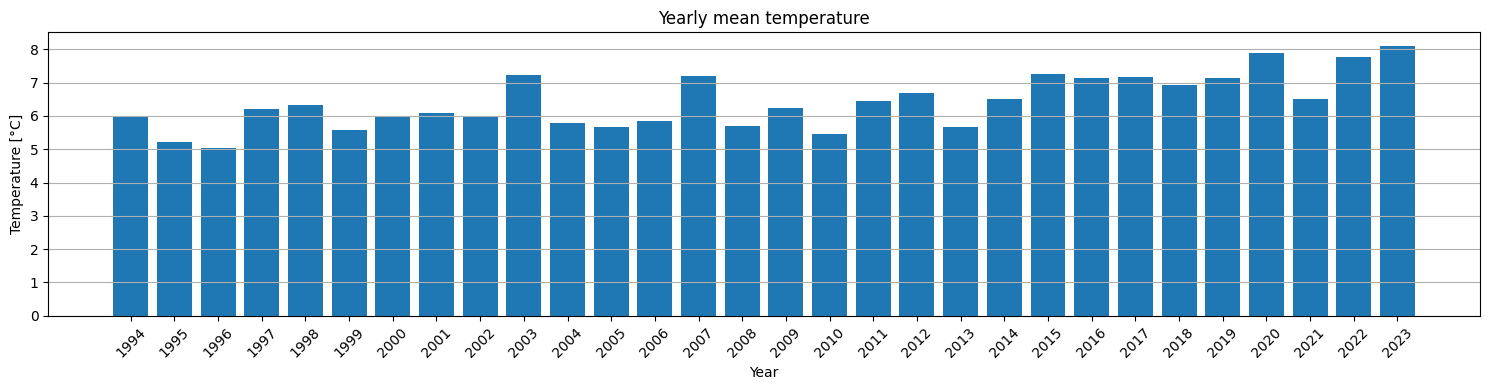

In [18]:
fig, ax = plt.subplots(figsize=(15, 4))
hydroY = np.arange(1994, 2024, 1)

ax.bar(hydroY, taY-273.15, width=0.8)

ax.set_title("Yearly mean temperature")
ax.set_ylabel("Temperature [°C]")
ax.set_xlabel("Year")

ax.set_xticks(hydroY)               
ax.tick_params(axis="x", rotation=45)

ax.grid(True, axis="y") 
plt.tight_layout()
plt.show()

### Temperature anomaly

In [19]:
anTY = np.zeros(30)
meanT = np.mean(taY[0:10])
anTY = taY - meanT

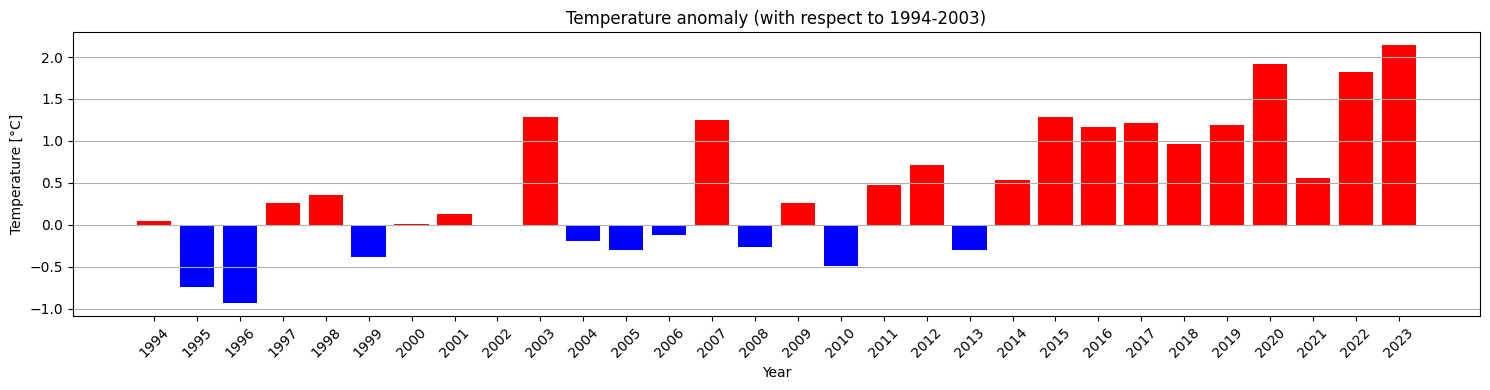

In [20]:
fig, ax = plt.subplots(figsize=(15, 4))
hydroY = np.arange(1994, 2024, 1)

colors = ["red" if val > 0 else "blue" for val in anTY]
ax.bar(hydroY, anTY, width=0.8, color=colors)

ax.set_title("Temperature anomaly (with respect to 1994-2003)")
ax.set_ylabel("Temperature [°C]")
ax.set_xlabel("Year")

ax.set_xticks(hydroY)               
ax.tick_params(axis="x", rotation=45)

ax.grid(True, axis="y") 
plt.tight_layout()
plt.show()

I would now like to identify which seasons are characterised by the greatest anomalies. For this reason, I divide the years into:
- Autumn: September --> November
- Winter: December --> February
- Spring: March --> May
- Summer: June --> August

In [21]:
auT = np.zeros(31)
inT = np.zeros(31)
prT = np.zeros(31)
esT = np.zeros(31)

for i in range(0, 31):
    auT[i] = (30*appo[8, i] + 31*appo[9, i] + 30*appo[10, i])/91
    inT[i] = (31*appo[11, i] + 31*appo[0, i] + 28*appo[1, i])/90
    prT[i] = (31*appo[2, i] + 30*appo[3, i] + 31*appo[4, i])/92
    if i < 30:
        esT[i] = (30*appo[5, i] + 31*appo[6, i] + 31*appo[7, i+1])/92
    else:
        esT[i] = (30*appo[5, i] + 31*appo[6, i] + 31*ta.sel(time="2024-08").mean().item())/92

meanA = np.mean(auT[0:10]); auA = auT - meanA
meanI = np.mean(inT[0:10]); inA = inT - meanI
meanP = np.mean(prT[0:10]); prA = prT - meanP
meanE = np.mean(esT[0:10]); esA = esT - meanE

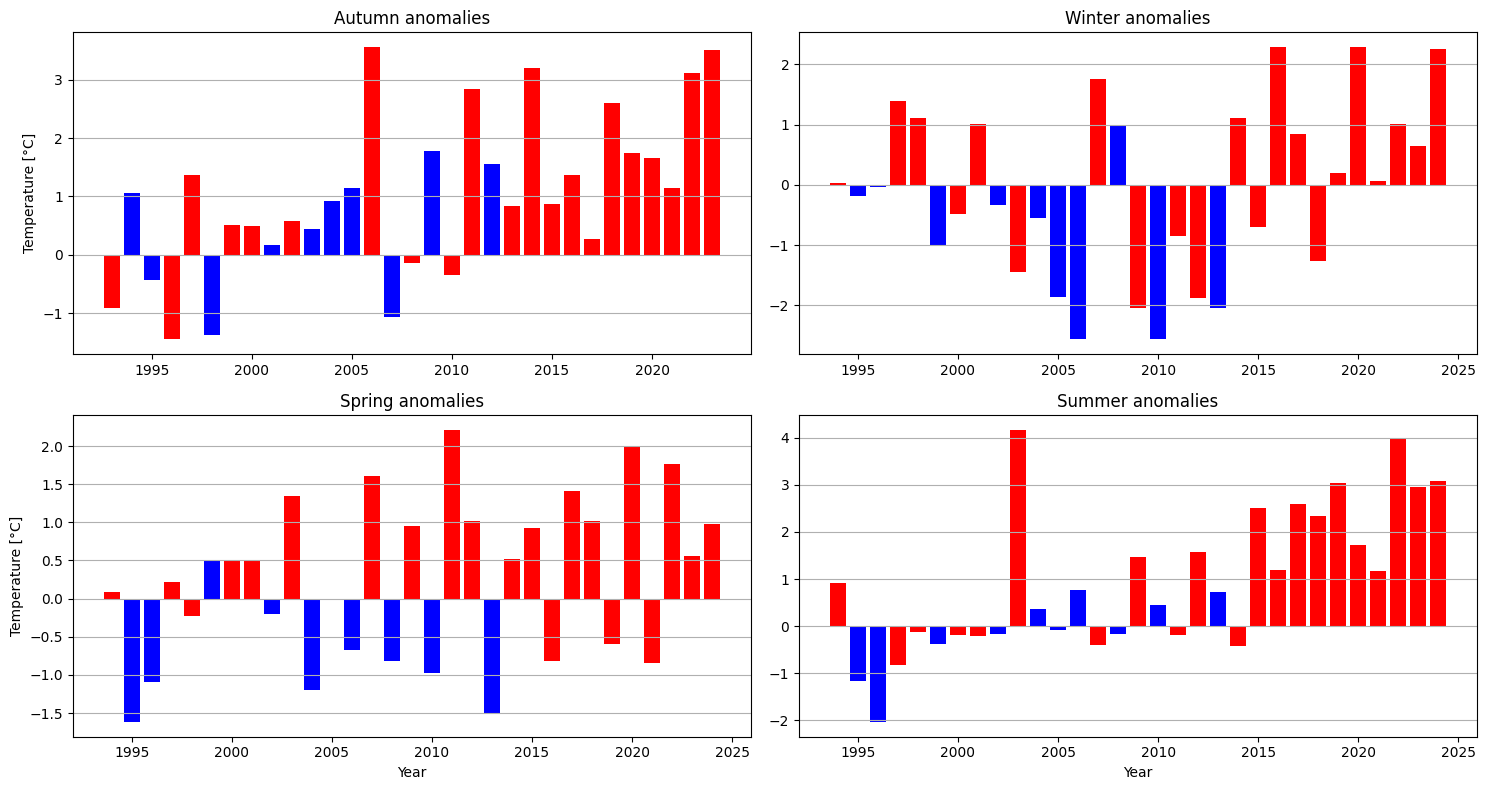

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(15, 8))
colors = ["red" if val > 0 else "blue" for val in anTY]

hydroY1 = np.arange(1993, 2024, 1)
hydroY2 = np.arange(1994, 2025, 1)

# Autumn anomalies
axs[0, 0].bar(hydroY1, auA, width=0.8, color=colors)
axs[0, 0].set_title("Autumn anomalies")
axs[0, 0].set_ylabel("Temperature [°C]")
axs[0, 0].grid(True, axis="y") 

# Winter anomalies
axs[0, 1].bar(hydroY2, inA, width=0.8, color=colors)
axs[0, 1].set_title("Winter anomalies")
axs[0, 1].grid(True, axis="y") 


# Spring anomalies
axs[1, 0].bar(hydroY2, prA, width=0.8, color=colors)
axs[1, 0].set_title("Spring anomalies")
axs[1, 0].set_ylabel("Temperature [°C]")
axs[1, 0].set_xlabel("Year")
axs[1, 0].grid(True, axis="y") 


# Summer anomalies
axs[1, 1].bar(hydroY2, esA, width=0.8, color=colors)
axs[1, 1].set_title("Summer anomalies")
axs[1, 1].set_xlabel("Year")
axs[1, 1].grid(True, axis="y") 


plt.tight_layout()
plt.show()